## Dataset

In [85]:
from classification_functions import *

In [2]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

## Exploring the data



In [86]:
df = pd.read_pickle('metatable_preprocessed.pkl')

In [5]:
df.groupby('tradition')['tradition'].count()

tradition
Американская литература          201
Античная литература               49
Британская литература             21
Европейская литература           543
Латиноамериканская литература     14
Прочая восточная литература        7
Прочая европейская литература     24
Прочая литература                113
Русская литература               499
Скандинавская литература          39
Name: tradition, dtype: int64

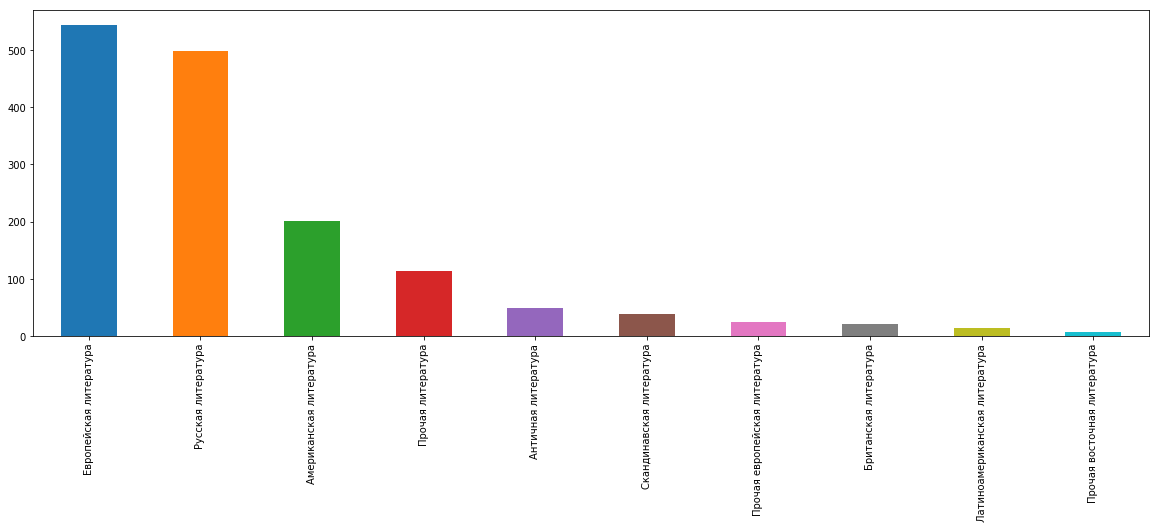

In [6]:
df.tradition.value_counts().plot(kind="bar")

In [7]:
# размер корпуса
df['text'].apply(lambda x: len(x.split(' '))).sum()

1926694

In [8]:
print_plot(df, 12, 'tradition')

Миссис Кремона — немолодая женщина с ласковой улыбкой и ясным кротким взглядом, пришла в огромное правительственное здание к сыну Джеральду, видному физику. Он был очень занят — беседовал с генералом Райнером. Генерал усомнился в уместности присутствия матушки Джеральда при их разговоре. Джеральд успокоил его — матушка ничего не понимает в их делах. Он объяснял генералу ситуацию. Одна из экспедиций, которая была отправлена за пояс астероидов, достигла Плутония. Они подают радиосигналы. Загадка в том, что люди отправились в полёт четыре года назад, а всех припасов им могло хватить от силы на год. Джеральд предположил, что, возможно, им помогают жители других планет. Надо срочно узнать, что происходит. Может быть, от этого зависит будущее человечества. Для этого нужен электронный мозг Мультивак. От Земли до Плутония около четырёх миллиардов миль. Даже если радиоволны будут распространяются со скоростью света, то они покроют это расстояние за шесть часов, значит, ответа придётся ждать две

### Train/test split

In [5]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

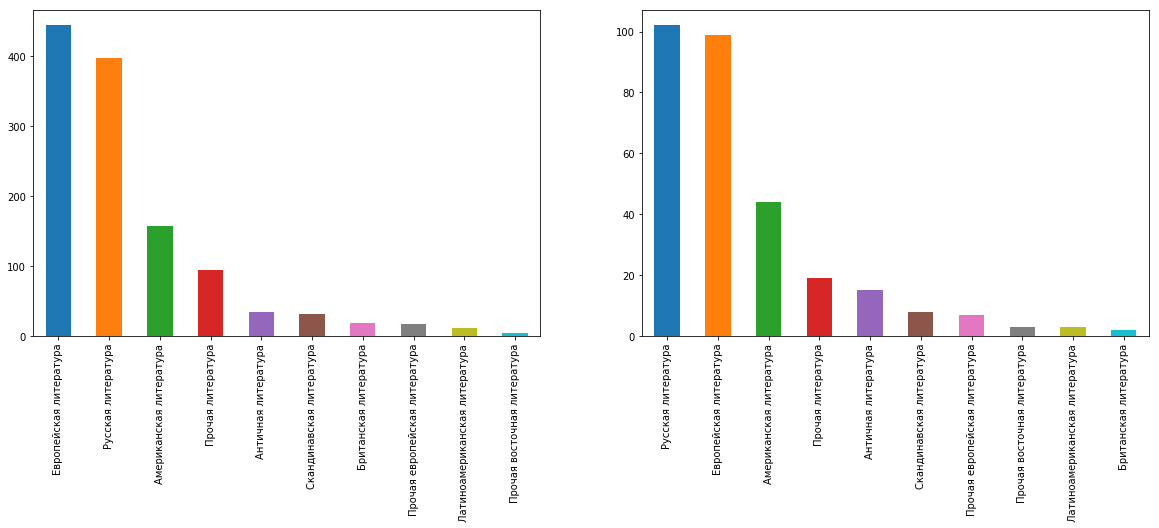

In [10]:
fig, axs = plt.subplots(1,2)
train_data.tradition.value_counts().plot(kind="bar", ax=axs[0])
test_data.tradition.value_counts().plot(kind="bar", ax=axs[1])

In [6]:
traditions = df.groupby('tradition')['tradition'].count().index

## Baseline: bag of words, n-grams, tf-idf
Let's start with some simple baselines before diving into more advanced methods.

In [7]:
STOPWORDS = stopwords.words('russian')
TOKENIZER = nltk.tokenize.word_tokenize

### Bag of words

The simplest document feature is just a count of each word occurrence in a document.

In [29]:
%%time

count_vectorizer = CountVectorizer(analyzer="word", max_features=3000, tokenizer=TOKENIZER, stop_words=STOPWORDS) 
train_data_features = count_vectorizer.fit_transform(train_data['text'])

CPU times: user 31.3 s, sys: 150 ms, total: 31.5 s
Wall time: 31.5 s


In [30]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tradition'])

CPU times: user 2.51 s, sys: 4.15 ms, total: 2.51 s
Wall time: 2.51 s


In [31]:
count_vectorizer.get_feature_names()[2680:2700]

['товарищей',
 'той',
 'толпа',
 'толпы',
 'тома',
 'томас',
 'томми',
 'тому',
 'тони',
 'тотчас',
 'точки',
 'точно',
 'трагедии',
 'требует',
 'требуют',
 'третий',
 'третьего',
 'тридцать',
 'трое',
 'троих']

accuracy 0.6920529801324503
confusion matrix
 [[24  0  0 11  0  0  0  1  8  0]
 [ 0 11  0  3  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 5  0  0 76  0  0  0  3 15  0]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  0  1  1  0]
 [ 2  0  0  5  0  0  0  0  0  0]
 [ 2  0  0  5  0  0  0  8  4  0]
 [ 4  0  0  9  0  0  0  2 85  2]
 [ 0  0  0  1  0  0  0  1  1  5]]
(row=expected, col=predicted)
CPU times: user 8.11 s, sys: 89.5 ms, total: 8.2 s
Wall time: 8.14 s


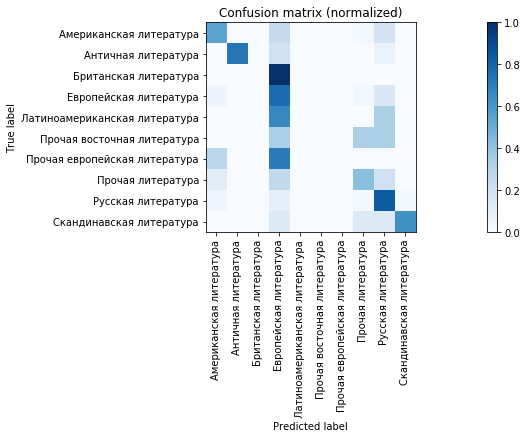

In [32]:
%%time

predict(count_vectorizer, logreg, test_data['text'], test_data['tradition'], traditions)

In [39]:
print(df.loc[0, 'tradition'])
logreg.predict(count_vectorizer.transform([df.loc[0, 'text']]))
df.loc[0, 'text'][:1000]

Русская литература


'На краю леса перед мельницей мельник Фаддей строгает доску для починки мельницы, повреждённой ветром. Он рассуждает о суевериях людей, убеждённых, что без колдуна ни одна мельница стоять не может. Но ведь сам-то он родился и вырос на мельнице и ни одного домового в глаза не видел. Уж если что и следует считать за колдовство, то это плутовство и обман. Появившийся Филимон — жених Анюты, дочери крестьянина Анкудина, просит мельника поворожить по поводу пропавших коней. Мельник, предчувствуя поживу, обещает исполнить просьбу, однако требует оплату вперёд. После продолжительного торга мельник соглашается ворожить и велит Филимону три раза повернуться по солнцу, затем один раз против солнца и подойти к дереву. В заключение мельник завязывает Филимону глаза платком и приказывает дожидаться его возвращения, не отвечая ни на чьи вопросы. Он очерчивает вокруг Филимона круг мелом и отходит. Струхнувший Филимон подбадривает себя песней. Мельник выносит жернова и, вращая их для создания шума, про

In [42]:
%%time

count_vectorizer_lemmatized = count_vectorizer.set_params(stop_words=None, lowercase=False, tokenizer=lambda x: x)
train_data_features_lemmatized = count_vectorizer_lemmatized.fit_transform(train_data['text_pymystem_list'])

CPU times: user 1.12 s, sys: 3.79 ms, total: 1.12 s
Wall time: 1.12 s


In [43]:
%%time

logreg = logreg.fit(train_data_features_lemmatized, train_data['tradition'])

CPU times: user 2.21 s, sys: 14 µs, total: 2.21 s
Wall time: 2.21 s


accuracy 0.7185430463576159
confusion matrix
 [[29  0  0  9  0  0  0  1  5  0]
 [ 0 12  0  2  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 4  0  0 83  0  0  1  3  7  1]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  8  4  0]
 [ 4  0  0 15  0  0  0  0 83  0]
 [ 0  0  0  5  0  0  0  0  1  2]]
(row=expected, col=predicted)
CPU times: user 533 ms, sys: 92 ms, total: 625 ms
Wall time: 518 ms


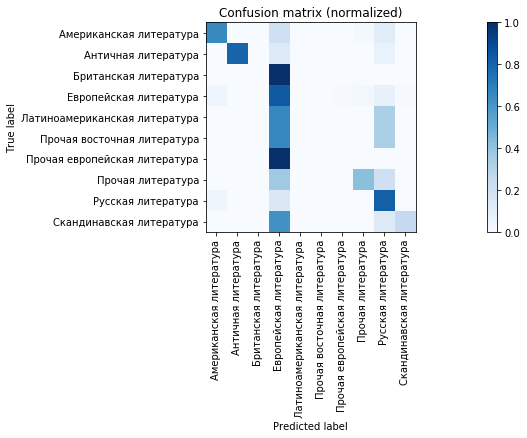

In [45]:
%%time

predict(count_vectorizer_lemmatized, logreg, test_data['text_pymystem_list'], test_data['tradition'], traditions)

In [46]:
tradition_tag_id = 0
print(traditions[tradition_tag_id])
most_influential_words(count_vectorizer, logreg, tradition_tag_id)

Американская литература


['часть',
 'доллар',
 'банк',
 'ферма',
 'индеец',
 'штат',
 'мост',
 'тома',
 'дерево',
 'находиться']

### Character N-grams

In [47]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=-1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['text'])

logreg = logreg.fit(train_data_features, train_data['tradition'])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


CPU times: user 1min 17s, sys: 1.03 s, total: 1min 18s
Wall time: 1min 18s


In [48]:
n_gram_vectorizer.get_feature_names()[50:60]

[' вм', ' вме', ' вн', ' во', ' во ', ' воз', ' вос', ' вр', ' вре', ' врем']

The results are worse than using a tokenizer and bag of words. Probably due to not removing the stop words.

accuracy 0.6920529801324503
confusion matrix
 [[25  0  0 11  0  0  0  0  7  1]
 [ 0 11  0  2  0  0  0  0  2  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 8  1  0 67  0  0  1  2 20  0]
 [ 1  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  1  0]
 [ 1  1  0  5  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0 10  5  1]
 [ 2  0  0  6  0  0  0  1 93  0]
 [ 1  0  0  3  0  0  0  0  1  3]]
(row=expected, col=predicted)


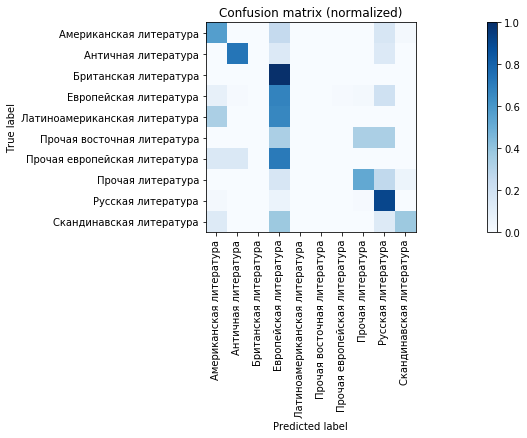

In [49]:
predict(n_gram_vectorizer, logreg, test_data['text'], test_data['tradition'], traditions)

### TF-IDF

[Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a little more advanced way to count words in a document.
It adjusts for document length, word frequency and most importantly for frequency of a particular word in a particular document.


In [55]:
%%time
tf_vect = TfidfVectorizer(min_df=2, tokenizer=lambda x: x, lowercase=False)
train_data_features = tf_vect.fit_transform(train_data['text_pymystem_list'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tradition'])

CPU times: user 4.11 s, sys: 15.6 ms, total: 4.12 s
Wall time: 4.13 s


In [11]:
tf_vect.get_feature_names()[1000:1010]

['бездумный',
 'бездушный',
 'бездыханный',
 'безжалостно',
 'безжалостность',
 'безжалостный',
 'безжизненно',
 'безжизненный',
 'беззаботно',
 'беззаботность']

accuracy 0.7649006622516556
confusion matrix
 [[29  0  0 11  0  0  0  0  4  0]
 [ 0 11  0  3  0  0  0  0  0  1]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 5  1  0 87  0  0  0  0  6  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  9  2  0]
 [ 2  0  0  7  0  0  0  0 93  0]
 [ 0  0  0  5  0  0  0  0  1  2]]
(row=expected, col=predicted)


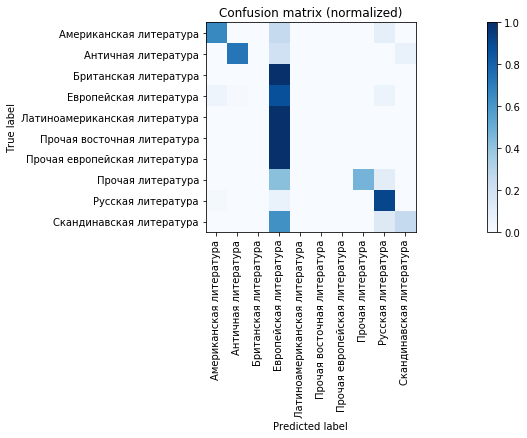

In [12]:
predict(tf_vect, logreg, test_data['text_pymystem_list'], test_data['tradition'], traditions)

In [13]:
tradition_tag_id = 0
print(traditions[tradition_tag_id])
most_influential_words(tf_vect, logreg, tradition_tag_id)

Американская литература


['питер',
 'доллар',
 'лэнгдон',
 'джек',
 'чарли',
 'нью',
 'юджин',
 'кира',
 'ганин',
 'индеец']

# Averaging word vectors

Now let's use more complex features rather than just counting words.

A great recent achievement of NLP is the [word2vec embedding](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). See Chris Moody's [video](https://www.youtube.com/watch?v=vkfXBGnDplQ) for a great introduction to word2vec. 


In [14]:
%%time 

path = '/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model'
model = FastText.load(os.getcwd() + path)
model.init_sims(replace=True)

2018-10-05 01:36:36,729 : INFO : loading FastText object from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model
2018-10-05 01:36:40,560 : INFO : loading wv recursively from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.* with mmap=None
2018-10-05 01:36:40,576 : INFO : loading syn0_vocab from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy with mmap=None
2018-10-05 01:36:42,579 : INFO : loading syn0 from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0.npy with mmap=None
2018-10-05 01:36:46,312 : INFO : setting ignored attribute syn0norm to None
2018-10-05 01:36:46,337 : INFO : setting ignored attr

CPU times: user 12.5 s, sys: 3.6 s, total: 16.1 s
Wall time: 47.8 s


Example vocabulary

In [15]:
from itertools import islice
list(islice(model.wv.vocab, 0, 20))

['плотоядный',
 'тиранический',
 'термопаста',
 'синь',
 'spaceshiptwo',
 'рный',
 'сакмарский',
 'куроедов',
 'отлагательный',
 'мизинчиковый',
 'фартинг',
 'библиотековедение',
 'монахова',
 'патология',
 'сиденко',
 'арзамасец',
 'высокомотивированный',
 'поохать',
 'световозвращающий',
 'идеальность']

The most naive way is just to take an average. [Mike Tamir](https://www.youtube.com/watch?v=7gTjYwiaJiU) has suggested that the resulting vector points to a single word summarising the whole document. For example all words in a book
 ‘A tale of two cities’ should add up to 'class-struggle’

In [16]:
test_tokenized = test_data['text_pymystem_list'].values
train_tokenized = train_data['text_pymystem_list'].values

In [17]:
%%time
X_train_word_average = word_averaging_list(model.wv, train_tokenized)
X_test_word_average = word_averaging_list(model.wv, test_tokenized)

CPU times: user 12.1 s, sys: 43.2 ms, total: 12.2 s
Wall time: 12.2 s


Let's see how KNN and logistic regression classifiers perform on these word-averaging document features.

In [18]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine')
knn_naive_dv.fit(X_train_word_average, train_data.tradition)

CPU times: user 6.61 ms, sys: 3.81 ms, total: 10.4 ms
Wall time: 28.8 ms


In [19]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

CPU times: user 21.3 ms, sys: 40.6 ms, total: 61.9 ms
Wall time: 53.3 ms


accuracy 0.7218543046357616
confusion matrix
 [[35  0  0  8  0  0  0  0  1  0]
 [ 0 13  0  2  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [13  5  1 75  0  0  0  2  2  1]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  2  0  1  0  0  0  0]
 [ 0  0  0  6  0  0  0  1  0  0]
 [ 0  1  0  8  0  0  0  9  1  0]
 [ 2  3  1 10  0  0  0  5 81  0]
 [ 1  0  0  2  0  0  0  1  0  4]]
(row=expected, col=predicted)


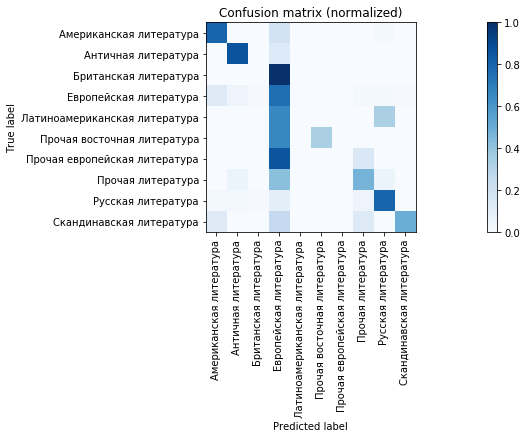

In [20]:
evaluate_prediction(predicted, test_data.tradition, traditions)

KNN is even worse than the naive 'everything is comedy' baseline! Let's see if logistic regression is better.

In [21]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data.tradition)
predicted = logreg.predict(X_test_word_average)

CPU times: user 3.83 s, sys: 324 ms, total: 4.15 s
Wall time: 3.84 s


accuracy 0.7450331125827815
confusion matrix
 [[29  0  3  8  0  0  0  1  2  1]
 [ 0 12  0  3  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 8  1  0 75  1  0  0  3  9  2]
 [ 1  0  0  1  0  0  0  1  0  0]
 [ 0  0  0  1  0  1  0  0  1  0]
 [ 0  1  0  5  0  0  0  1  0  0]
 [ 0  0  0  6  0  0  0 13  0  0]
 [ 4  0  0  6  1  0  0  2 89  0]
 [ 0  0  0  1  0  0  0  0  1  6]]
(row=expected, col=predicted)


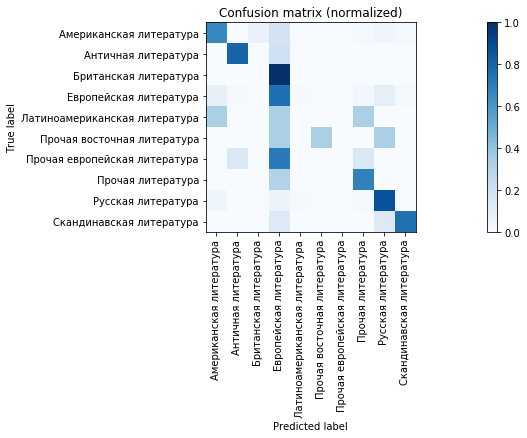

In [22]:
evaluate_prediction(predicted, test_data.tradition, traditions)

Now just for fun let's see if text summarisation works on our data. Let's pick a plot and see which words it averages to.

In [23]:
test_data.iloc()[56]['text']

'Семнадцатилетний Мелькур вступил в свет, «обладая всем, что требуется, дабы не остаться незамеченным». От отца он унаследовал прекрасное имя, со стороны матери его ожидало большое состояние. Время было мирное, и Мелькур ни о чем не помышлял, кроме удовольствий. Среди суеты и блеска юноша страдал от сердечной пустоты и мечтал изведать любовь, о которой имел лишь самое смутное представление. Наивный и неопытный, Мелькур не знал, как завязываются любовные связи в высшем кругу. С одной стороны, он был о себе достаточно высокого мнения, с другой — полагал, что успех у женщин может иметь только человек выдающийся, и не надеялся заслужить их благосклонность. Мелькур стал все больше думать о подруге своей матери маркизе де Люрсе и убедил себя, что влюблён в неё. Некогда маркиза слыла кокеткой и даже ветреницей, но впоследствии усвоила строгий и добродетельный тон, поэтому Мелькур, не знавший о её прошлом, считал её неприступной. Маркиза без труда догадалась о чувствах Мелькура и была готова н

In [24]:
model.wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

[('опростоволоситься', 0.7897706627845764),
 ('симоронить', 0.7883868217468262),
 ('гленарывать', 0.7708706259727478),
 ('разоткровенничаться', 0.7665129899978638),
 ('растрогаться', 0.760732889175415),
 ('даринька', 0.7581226825714111),
 ('думать', 0.7577769756317139),
 ('кажется', 0.7547581791877747),
 ('примолкать', 0.7545772790908813),
 ('вернее', 0.7522390484809875),
 ('порассказать', 0.7449817657470703),
 ('затосковать', 0.7414664030075073),
 ('присоветовать', 0.7414649724960327),
 ('заспорить', 0.7407478094100952),
 ('уговариваться', 0.7404695749282837),
 ('нездоровиться', 0.7393044233322144),
 ('расстараться', 0.7383365035057068),
 ('застесняться', 0.7381041049957275),
 ('обратиться', 0.7377612590789795),
 ('смериться', 0.7364529371261597)]

# Doc2Vec

In [25]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [26]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=r['text_pymystem_list'], tags=[r.tradition]), axis=1)

In [27]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=r['text_pymystem_list'], tags=[r.tradition]), axis=1)

In [28]:
test_tagged.values[50]

TaggedDocument(words=['жизнь', 'необыкновенный', 'удивительный', 'приключение', 'робинзон', 'крузо', 'моряк', 'йорк', 'проживать', 'год', 'полный', 'одиночество', 'необитаемый', 'остров', 'берег', 'америка', 'близ', 'устье', 'река', 'ориноко', 'выбрасывать', 'корабль', 'крушение', 'время', 'который', 'весь', 'экипаж', 'корабль', 'кроме', 'погибать', 'изложение', 'неожиданный', 'освобождение', 'пират', 'написать', 'робинзон', 'третий', 'сын', 'семья', 'баловень', 'готовить', 'ремесло', 'детский', 'год', 'голова', 'набивать', 'всякий', 'бредень', 'главный', 'образ', 'мечта', 'морской', 'путешествие', 'старший', 'брат', 'погибать', 'фландрия', 'сражаться', 'испанец', 'весть', 'пропадать', 'средний', 'поэтому', 'дома', 'слышать', 'хотеть', 'отпускать', 'последний', 'сын', 'море', 'отец', 'человек', 'степенный', 'умный', 'слезный', 'умолять', 'стремиться', 'скромный', 'существование', 'весь', 'лад', 'превозносить', 'средний', 'состояние', 'уберегать', 'человек', 'здравомыслящий', 'злой', 'п

In [29]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=-1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

/home/zu_ann/.local/lib/python3.5/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/home/zu_ann/.local/lib/python3.5/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2018-10-05 01:38:35,229 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-10-05 01:38:35,230 : INFO : collecting all words and their counts
2018-10-05 01:38:35,231 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-10-05 01:38:35,618 : INFO : collected 51807 word types and 10 unique tags from a corpus of 1208 examples and 1010005 words
2018-10-05 01:38:35,624 

CPU times: user 44.2 s, sys: 31.4 ms, total: 44.2 s
Wall time: 44.3 s


Interesting thing about doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs of the next cell.

Consequently, the accuracy of logistic regression changes when the test set vectors change.

In [30]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 11.9 s, sys: 32.1 ms, total: 11.9 s
Wall time: 11.9 s


accuracy 0.33112582781456956
confusion matrix
 [[ 0  0  0 41  0  0  0  0  3  0]
 [ 0  0  0 13  0  0  0  0  2  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 87  0  0  0  0 12  0]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  2  0]
 [ 0  0  0 15  0  0  0  0  4  0]
 [ 0  0  0 89  0  0  0  0 13  0]
 [ 0  0  0  8  0  0  0  0  0  0]]
(row=expected, col=predicted)


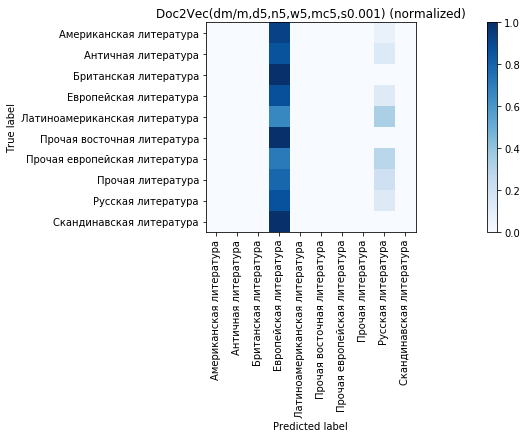

In [31]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, traditions, title=str(doc2vec_model))

2018-10-05 01:40:31,423 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.08278145695364239
confusion matrix
 [[ 1 14  3  0  8  2  0  4  7  5]
 [ 0  2  1  0  4  4  0  1  3  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 3 15 13  2 20  4  8  9 19  6]
 [ 0  1  1  0  0  0  0  1  0  0]
 [ 0  0  1  0  0  1  0  0  1  0]
 [ 1  3  1  1  0  0  0  1  0  0]
 [ 0  2  2  0  2  1  1  2  4  5]
 [ 7 19  9  3 18 10  3  7 17  9]
 [ 1  0  2  0  2  0  0  1  2  0]]
(row=expected, col=predicted)
CPU times: user 288 ms, sys: 95.6 ms, total: 384 ms
Wall time: 281 ms


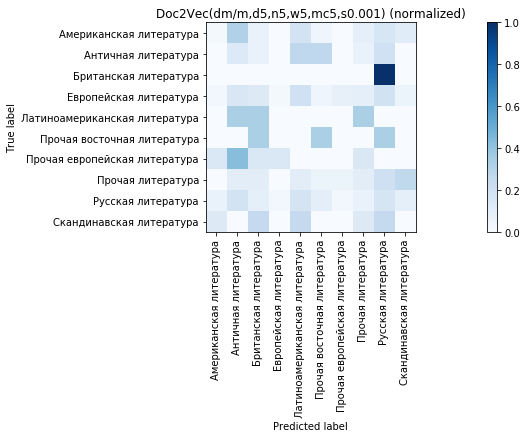

In [32]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, traditions, str(doc2vec_model))

Doc2vec gives us a vector for each tradition so we can see which genres are close together.

In [33]:
doc2vec_model.docvecs.most_similar('Русская литература')

[('Британская литература', 0.6610965132713318),
 ('Прочая европейская литература', 0.14513517916202545),
 ('Прочая восточная литература', 0.10357614606618881),
 ('Европейская литература', 0.06612209975719452),
 ('Американская литература', -0.1874367594718933),
 ('Скандинавская литература', -0.25218474864959717),
 ('Латиноамериканская литература', -0.26167771220207214),
 ('Прочая литература', -0.328442245721817),
 ('Античная литература', -0.8482159376144409)]

In [34]:
model.wv.most_similar('Русская литература')

[('восточнопрусский', 0.7164652347564697),
 ('сочинительский', 0.7103330492973328),
 ('старобелорусский', 0.7035158276557922),
 ('залесская', 0.7008966207504272),
 ('вокульский', 0.6994539499282837),
 ('старосельская', 0.6962095499038696),
 ('антропонимический', 0.6920877695083618),
 ('золотусский', 0.6917855739593506),
 ('миропольский', 0.6910200715065002),
 ('староства', 0.6906902194023132)]

### Doc2vec exercise

10 mins

Find the random seed that gives the best prediction. :)



accuracy 0.33774834437086093
confusion matrix
 [[ 0  0  0 36  0  0  0  0  8  0]
 [ 0  0  0 14  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 85  0  0  0  0 14  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  4  0  0  0  0  3  0]
 [ 0  0  0 14  0  0  0  0  5  0]
 [ 0  0  0 85  0  0  0  0 17  0]
 [ 0  0  0  8  0  0  0  0  0  0]]
(row=expected, col=predicted)


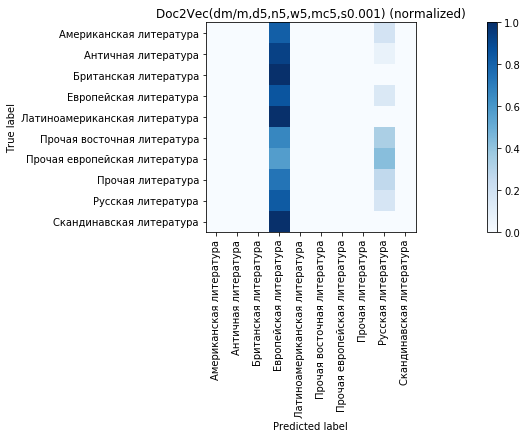

In [52]:
seed = 100

doc2vec_model.seed = seed
doc2vec_model.random = random.RandomState(seed)


test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])


logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, random_state=42)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, traditions, title=str(doc2vec_model))

# Deep IR

'Deep IR' is a technique developed by  [“Document Classification by Inversion of Distributed Language Representations”, Matt Taddy](http://arxiv.org/pdf/1504.07295v3.pdf). Matt has contributed a gensim [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) - great source of more in depth information.

In short the algorithm is:

1. Train a word2vec model only on comedy plots.

2. Trian another model only on one tradition, another on the other one etc. Get 6 models - one for each genre.

3. Take a plot and see which model fits it best using Bayes' Theorem



The tokenization is different from other methods. The reason for this is that we are following an original approach in the paper. The purpose of this tutorial is to see how the models behave out of the box.

We just clean non-alphanumeric characters and split by sentences.

In [35]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")


In [36]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['tradition'],\
        'x':[clean(s).split() for s in sentences(row['text'])]}

In [37]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

CPU times: user 11.8 s, sys: 195 ms, total: 12 s
Wall time: 12 s


In [38]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [39]:
def tag_sentences(reviews, stars=traditions):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

An example `sci-fi` sentence:

In [40]:
next(tag_sentences(revtrain, traditions[0]))

['маркетинг',
 'непрерывный',
 'процесс',
 'охватывающий',
 'все',
 'способы',
 'какими',
 'компания',
 'представляет',
 'себя',
 'миру',
 'чем',
 'вас',
 'ассоциируется',
 'слово',
 'маркетинг',
 '?']

We train our own 6 word2vec models from scratch. 

In [41]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(traditions))]
for i in range(len(traditions)):
    slist = list(tag_sentences(revtrain, traditions[i]))
    print(traditions[i], "genre (", len(slist), ")")
    genremodels[i].train(  slist, total_examples=len(slist), epochs=1 )
# get the probs (note we give docprob a list of lists of words, plus the models)

2018-10-05 01:41:07,596 : INFO : collecting all words and their counts
2018-10-05 01:41:07,598 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Word2Vec(vocab=0, size=100, alpha=0.025)


2018-10-05 01:41:07,713 : INFO : PROGRESS: at sentence #10000, processed 115909 words, keeping 32593 word types
2018-10-05 01:41:07,792 : INFO : PROGRESS: at sentence #20000, processed 231537 words, keeping 52452 word types
2018-10-05 01:41:07,898 : INFO : PROGRESS: at sentence #30000, processed 350065 words, keeping 67717 word types
2018-10-05 01:41:07,995 : INFO : PROGRESS: at sentence #40000, processed 468520 words, keeping 80836 word types
2018-10-05 01:41:08,085 : INFO : PROGRESS: at sentence #50000, processed 585657 words, keeping 92322 word types
2018-10-05 01:41:08,182 : INFO : PROGRESS: at sentence #60000, processed 704943 words, keeping 103254 word types
2018-10-05 01:41:08,271 : INFO : PROGRESS: at sentence #70000, processed 825245 words, keeping 113603 word types
2018-10-05 01:41:08,366 : INFO : PROGRESS: at sentence #80000, processed 943333 words, keeping 123181 word types
2018-10-05 01:41:08,442 : INFO : PROGRESS: at sentence #90000, processed 1062456 words, keeping 13249

Американская литература genre ( 17899 )


2018-10-05 01:41:29,280 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-05 01:41:29,303 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-10-05 01:41:29,308 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-10-05 01:41:29,309 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-10-05 01:41:29,311 : INFO : EPOCH - 1 : training on 203770 raw words (159320 effective words) took 0.5s, 345563 effective words/s
2018-10-05 01:41:29,312 : INFO : training on a 203770 raw words (159320 effective words) took 0.5s, 337261 effective words/s
2018-10-05 01:41:29,313 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-10-05 01:41:29,316 : INFO : training model with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2018-10-05 01:41:29,432 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10

Античная литература genre ( 3727 )
Британская литература genre ( 2015 )


2018-10-05 01:41:29,530 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-05 01:41:29,561 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-10-05 01:41:29,570 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-10-05 01:41:29,584 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-10-05 01:41:29,585 : INFO : EPOCH - 1 : training on 25780 raw words (20195 effective words) took 0.1s, 225677 effective words/s
2018-10-05 01:41:29,587 : INFO : training on a 25780 raw words (20195 effective words) took 0.1s, 188448 effective words/s
2018-10-05 01:41:29,590 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-10-05 01:41:29,601 : INFO : training model with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


Европейская литература genre ( 43800 )


2018-10-05 01:41:30,637 : INFO : EPOCH 1 - PROGRESS: at 94.15% examples, 400819 words/s, in_qsize 4, out_qsize 0
2018-10-05 01:41:30,640 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-05 01:41:30,653 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-10-05 01:41:30,680 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-10-05 01:41:30,681 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-10-05 01:41:30,682 : INFO : EPOCH - 1 : training on 550622 raw words (435100 effective words) took 1.1s, 406922 effective words/s
2018-10-05 01:41:30,684 : INFO : training on a 550622 raw words (435100 effective words) took 1.1s, 402180 effective words/s
2018-10-05 01:41:30,690 : INFO : training model with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2018-10-05 01:41:30,718 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-05 01:41:30,72

Латиноамериканская литература genre ( 879 )
Прочая восточная литература genre ( 736 )
Прочая европейская литература genre ( 1498 )
Прочая литература genre ( 8077 )


2018-10-05 01:41:31,081 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-05 01:41:31,118 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-10-05 01:41:31,127 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-10-05 01:41:31,132 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-10-05 01:41:31,133 : INFO : EPOCH - 1 : training on 88464 raw words (69527 effective words) took 0.2s, 302352 effective words/s
2018-10-05 01:41:31,134 : INFO : training on a 88464 raw words (69527 effective words) took 0.3s, 275404 effective words/s
2018-10-05 01:41:31,135 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-10-05 01:41:31,145 : INFO : training model with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


Русская литература genre ( 34602 )


2018-10-05 01:41:31,884 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-05 01:41:31,903 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-10-05 01:41:31,910 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-10-05 01:41:31,915 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-10-05 01:41:31,915 : INFO : EPOCH - 1 : training on 379960 raw words (292444 effective words) took 0.8s, 385746 effective words/s
2018-10-05 01:41:31,916 : INFO : training on a 379960 raw words (292444 effective words) took 0.8s, 379808 effective words/s
2018-10-05 01:41:31,918 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-10-05 01:41:31,921 : INFO : training model with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2018-10-05 01:41:31,983 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10

Скандинавская литература genre ( 2869 )
CPU times: user 26.4 s, sys: 684 ms, total: 27.1 s
Wall time: 24.4 s


Now we will compute most likely class for a plot using Bayes' Theorem formula.

<img src='images/deep_ir_bayes.png' width=600>

For any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences. This is all in the following handy wrapper. (from the original [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) by Matt Taddy.

In [42]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [43]:
%%time
## predict
probs = docprob([r['x'] for r in revtest], genremodels)  
predictions = probs.idxmax(axis=1).apply(lambda x: traditions[x])

2018-10-05 01:41:32,094 : INFO : scoring sentences with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-10-05 01:41:33,098 : INFO : PROGRESS: at 2860000.00% sentences, 28502 sentences/s
2018-10-05 01:41:33,101 : INFO : reached end of input; waiting to finish 12 outstanding jobs
2018-10-05 01:41:33,138 : INFO : scoring 29991 sentences took 1.0s, 28758 sentences/s
2018-10-05 01:41:33,140 : INFO : scoring sentences with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-10-05 01:41:34,061 : INFO : reached end of input; waiting to finish 12 outstanding jobs
2018-10-05 01:41:34,091 : INFO : scoring 29991 sentences took 1.0s, 31568 sentences/s
2018-10-05 01:41:34,092 : INFO : scoring sentences with 4 workers on 33707 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-10-05 01:41:35,028 : INFO : reached end of input; waiting to finish 12 outstanding jobs
2018-10-05 01:41:3

CPU times: user 14.1 s, sys: 2.49 s, total: 16.6 s
Wall time: 9.7 s


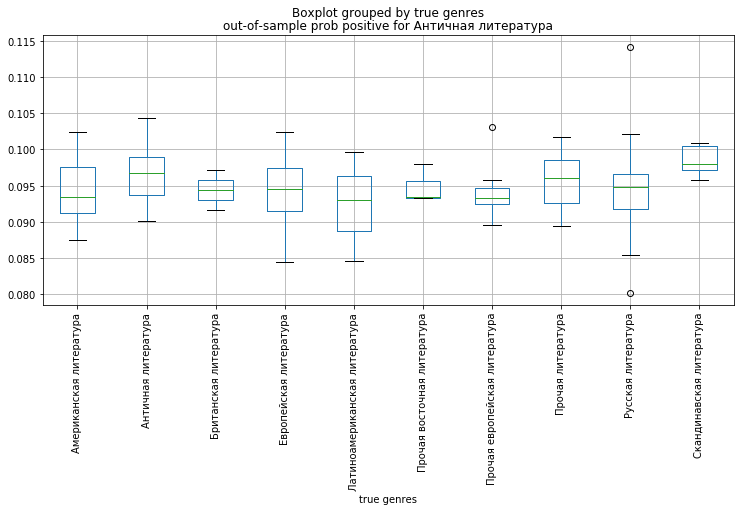

In [44]:
tag_index = 1
col_name = "out-of-sample prob positive for " + traditions[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5), rot=90)

In [45]:
target = [r['y'] for r in revtest]

accuracy 0.4139072847682119
confusion matrix
 [[15  0  0 19  0  0  0  9  1  0]
 [ 1  0  0 12  0  0  0  0  2  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 1  0  0 91  0  0  0  5  2  0]
 [ 0  0  0  2  0  0  0  1  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  1  0  0]
 [ 1  0  0 13  0  0  0  3  2  0]
 [ 3  0  1 72  0  0  0 10 16  0]
 [ 0  0  0  5  0  0  0  3  0  0]]
(row=expected, col=predicted)


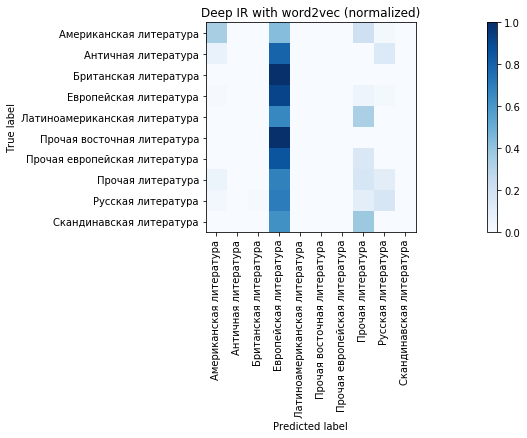

In [46]:
evaluate_prediction(predictions, target, traditions, "Deep IR with word2vec")